## Лабораторная работа 7. Решающие деревья

В этой домашке мы будем работать с набором данных с платформы kaggle в формате соревнования и по ходу этой и следующей лабораторной работы узнаем как правильно организовать решение соревнования, чтобы удобно было воспользоваться техниками ансамблирования решений и адекватно оценить какие идеи в нашем решении привели к улучшениям нашего итогового результата.

Кроме того, в этой домашке мы познакомимся с новыми классами моделей — деревьями и случайными лесами.

План такой:
* Пишем новые модели, над которыми будем экспериментировать
* Пишем пайплайн для ведения и сравнения экспериментов
* Мучаем наши новые модели и модели, которые мы уже знаем, для достижения высокого качества на тестовой выборке
* Применяем ансамблирование и получаем топовый результат

Ссылка на Контест:
https://contest.yandex.ru/contest/54729/problems/

**1. (1 балл)** Загрузите в Контест решение первой задачи (см. файл `src.py`).

**2. (1 балл)** Загрузите в Контест решение второй задачи (см. файл `src.py`).

**3. (2 балла)** Загрузите в Контест решение третьей задачи (см. файл `src.py`).

**4. (2 балла)** Загрузите в Контест решение четвёртой задачи (см. файл `src.py`).

#### 5. (2 балла) Решающее дерево
Допишите `sklearn`-совместимый класс `MyDecisionTreeClassifier` в `src.py`, убедитесь, что он проходит тесты в проверяющей системе.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from src import MyDecisionTreeClassifier

Мы хотим посмотреть на него в картинках, так что воспользуемся удобной библиотечкой `mlxtend`, которая позволяет взмахом руки получать подробные графики работы модели.

In [2]:
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 1.6 MB/s eta 0:00:01


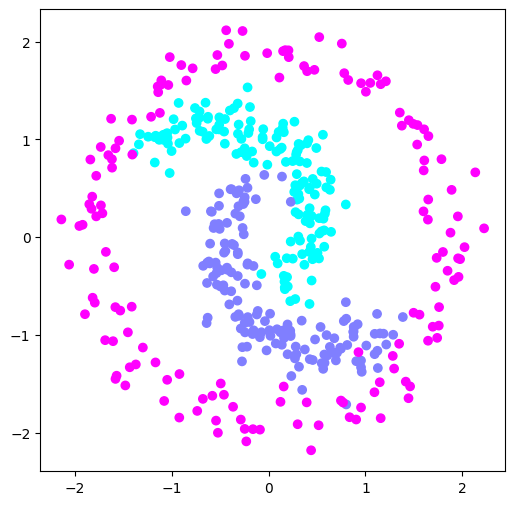

In [3]:
def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise, random_state=0xC0FFEE)
    if not n_sun:
        return X_moons, y_moons
    
    rng = np.random.default_rng(0xC0FFEE)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += rng.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)

    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)

    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X = X @ R
    
    return X, y

X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)
_ = plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='cool')
plt.show();

/home/avalur/autohw/dt/ref_tree_predict.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._predicted_class = self._meta.rng.choice(mode(y)[0])


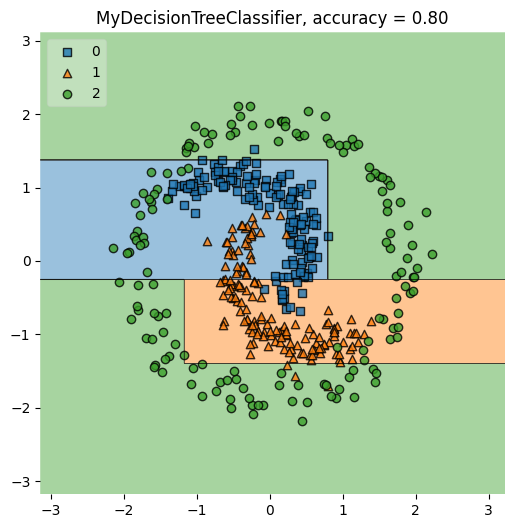

In [4]:
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score

def make_clf_plot(classifier, axis):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")

_ = plt.figure(figsize=(6, 6))
axis = plt.axes()
make_clf_plot(MyDecisionTreeClassifier(max_depth=4, seed=42), axis)

Поменяйте параметры дерева — глубину или минимальное количество сэмплов для сплита, посмотрите на картинки и значения точности для этих случаев

/home/avalur/autohw/dt/ref_tree_predict.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._predicted_class = self._meta.rng.choice(mode(y)[0])
/home/avalur/autohw/dt/ref_tree_predict.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._predicted_cl

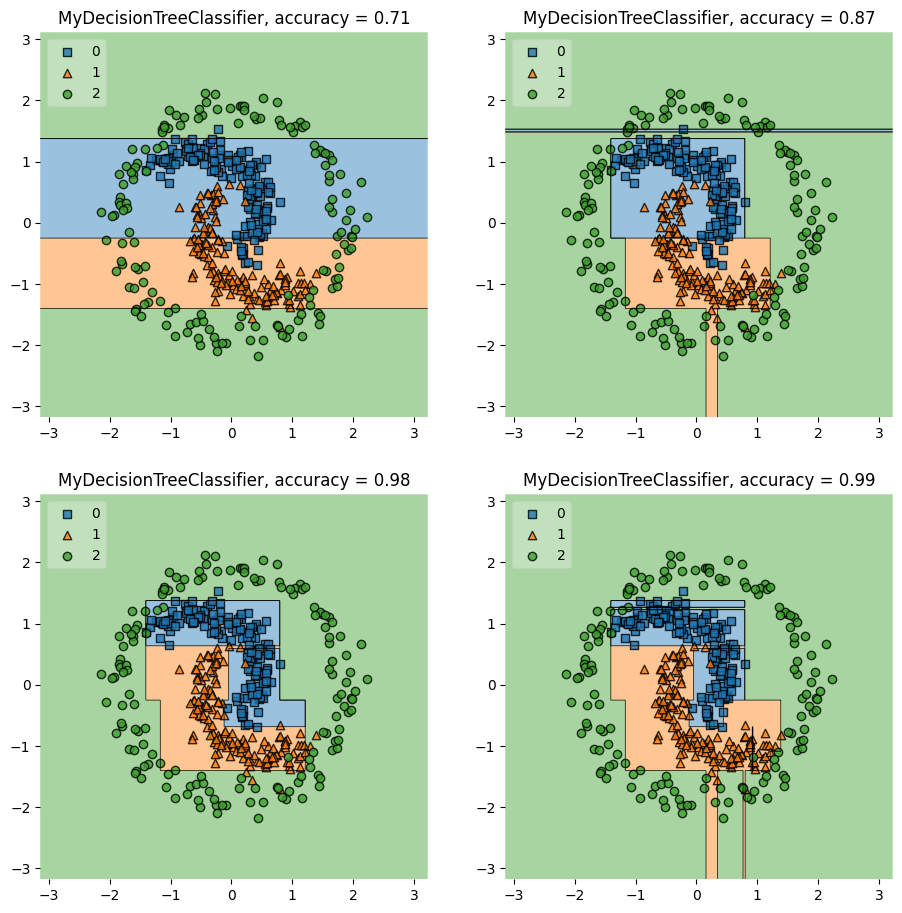

In [5]:
cases = [
    MyDecisionTreeClassifier(max_depth=3, seed=42),
    MyDecisionTreeClassifier(max_depth=5, seed=42),
    MyDecisionTreeClassifier(max_depth=None, min_samples_split=20, seed=42),
    MyDecisionTreeClassifier(max_depth=None, min_samples_split=5, seed=42),
]

def make_clf_plot(classifier, axis):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11, 11))

for classifier, axis in zip(cases, axes.flat):
    make_clf_plot(classifier, axis)

##### Делаем красиво с помощью фича-инжиниринга

Воспользуйтесь пайплайнами (`Pipeline`) из `sklearn`, чтобы предобработать наши признаки для получения более информативных и достигните высокого качества на обучающей выборке с маленькой глубиной дерева и сравните с линейной моделью на нелинейных признаках

In [6]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

/home/avalur/autohw/dt/ref_tree_predict.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._predicted_class = self._meta.rng.choice(mode(y)[0])


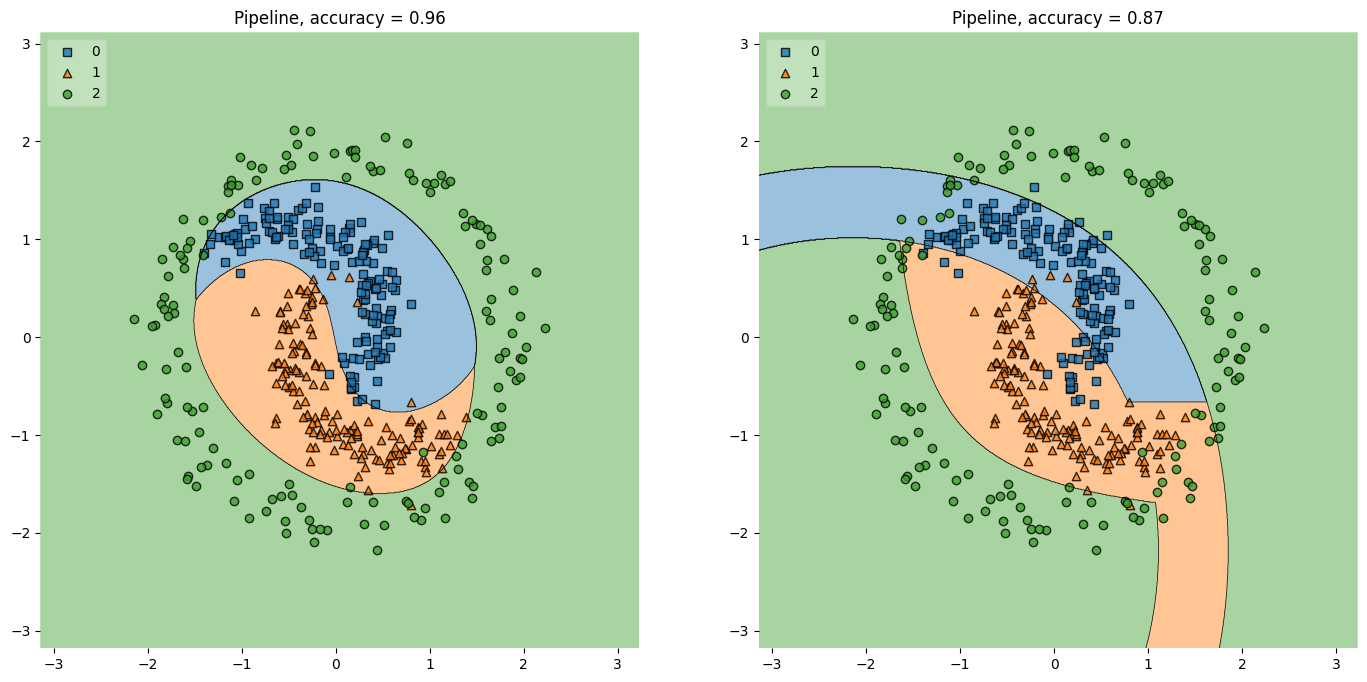

In [7]:
logreg_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42)),
])

tree_pipeline = Pipeline([
    ('standartization', MinMaxScaler()),
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('tree', MyDecisionTreeClassifier(max_depth=4, seed=42)),
])

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(17, 8))

for classifier, axis in zip((logreg_pipeline, tree_pipeline), axes):
    make_clf_plot(classifier, axis)

##### 6. (2 балла) Случайный лес
Допишите `sklearn`-совместимый класс `MyRandomForestClassifier` в `src.py`, убедитесь, что он проходит тесты в проверяющей системе.\
Посмотрите как он работает на сгенерированных данных, наблюдается ли улучшение от ансамблирования?

/home/avalur/autohw/dt/ref_forest.py:136: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self._predicted_class = self._meta.rng.choice(mode(y)[0])


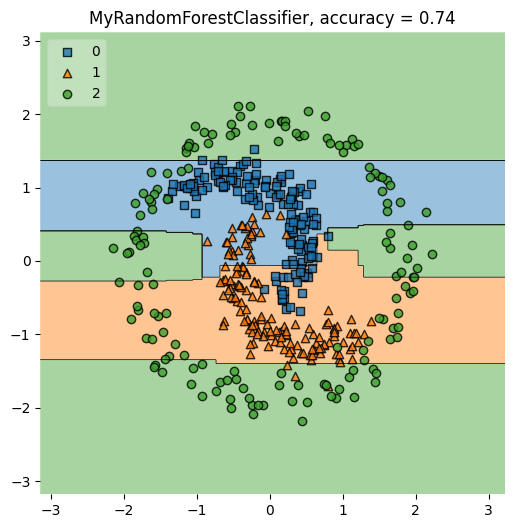

In [8]:
from src import MyRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
_ = plt.figure(figsize=(6, 6))
axis = plt.axes()
make_clf_plot(MyRandomForestClassifier(n_estimators=100, max_depth=3, seed=42), axis)

*Ниже можно использовать `DecisionTreeClassifier` и `RandomForestClassifier` из `sklearn`, поскольку они имплементированы на `Cython`* $=>$ *работают быстрее и обладают большим числом настраиваемых параметров.*

#### Серьезные данные
##### Получаем датасет

Ссылка на публичный датасет https://www.kaggle.com/purumalgi/music-genre-classification \
Ознакомьтесь с описанием, поймите о какой задаче и каких данных идет речь, можно удовлетворить некоторое любопытство в `Data Explorer'e`, но в целом мы разберемся с этим по ходу ноутбука \
Мы сразу научимся работать с данными на kaggle (почти) без использования графического интерфейса при помощи kaggle-api, это полезно, например, если нам надо залить данные на сервер с консольным доступом и обработать их там.

Если у вас менеджер пакетов pip, то запустите эту команду из того же окружения то и юпитер-ноутбук (например в новой ячейке) \
`!pip install kaggle` \
Если conda, то вот эту \
`!conda install -c conda-forge kaggle`

Теперь ваша задача зайти в свой аккаунт в kaggle (создайте, если его еще нет) и создать API токен, чтобы авторизовать все действия из командной строки, такие как загрузка датасета или ноутбука. Подробная инструкция есть тут https://github.com/Kaggle/kaggle-api#api-credentials \
Когда ваш токен готов, полложите `kaggle.json` по нужному адресу или создайе соответствующие переменные окружения:
```
!export KAGGLE_USERNAME=username
!export KAGGLE_KEY=key
```

Теперь скачаем датасет и положим рядом с ноутбуком

In [12]:
!kaggle datasets download -d purumalgi/music-genre-classification

  0%|                                               | 0.00/1.29M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 1.29M/1.29M [00:00<00:00, 13.8MB/s]


Разархивируем даннные в папку `data`

In [14]:
!unzip music-genre-classification.zip -d ./data

Archive:  music-genre-classification.zip
  inflating: ./data/submission.csv   
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


Посмотрим на данные, что до нас доехали

In [15]:
import pandas as pd
train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')
submission_csv = pd.read_csv('./data/submission.csv')

In [16]:
train_csv.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [17]:
test_csv.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,David Bowie,Space Oddity - 2015 Remaster,73.0,0.310,0.403,NaN,-13.664,1,0.0326,0.07260,0.000093,0.1390,0.466,134.480,318027.000000,4
1,Crimson Sun,Essence of Creation,34.0,0.511,0.955,1.0,-5.059,1,0.1290,0.00040,0.000009,0.2630,0.291,151.937,220413.000000,4
2,P!nk,Raise Your Glass,78.0,0.700,0.709,7.0,-5.006,1,0.0839,0.00480,NaN,0.0289,0.625,122.019,202960.000000,4
3,Shawn Mendes,Wonder,80.0,0.333,0.637,1.0,-4.904,0,0.0581,0.13100,0.000018,0.1490,0.132,139.898,172693.000000,4
4,Backstreet Boys,Helpless When She Smiles - Radio Version,48.0,0.393,0.849,11.0,-4.114,1,0.0459,0.00421,NaN,0.1620,0.222,74.028,4.093117,4


In [18]:
submission_csv.head()

,Acoustic/Folk_0,Alt_Music_1,Blues_2,Bollywood_3,Country_4,HipHop_5,Indie Alt_6,Instrumental_7,Metal_8,Pop_9,Rock_10
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


##### Посмотрим на данные с точки зрения "бизнес-логики"

На данный момент наша цель понять, какая задача машинного обучения перед нами стоит, какими подходами ее решать, как измерять качество нашего решения и как правильно организовать неминуемо итеративный процесс модификации и валидации наших идей. Пока мы *не* ставим цель найти закономерности в данных и придумать наиболее эффективные фичи и модели для достижения наилучшего качества

На страничке датасета есть такое описание
```
Context
    Dataset is acquired from one of the MachineHack Hackathon

Content
    Training dataset: 17,996 rows with 17 columns

Column details: artist name; track name; popularity; ‘danceability’; energy; key; loudness; mode; ‘speechiness’; ‘acousticness’; ‘instrumentalness’; liveness; valence; tempo; duration in milliseconds and time_signature.

Target Variable: 'Class’ such as Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood,

Test dataset: 7,713 rows with 16 columns

Acknowledgements
    The entire credit goes to MachineHack where different hackathons are hosted for practice and learning.

Inspiration
    The hackathon uses Log Loss Metric to evaluate the results.
```

Из него мы можем понять, что в тренировочных данных есть метаинформация о музыкальных треках (`duration in milliseconds, time_signature, key, loudness, etc`) и некоторая пользовательская оценка звуковых характеристик (`‘danceability’, ‘speechiness’, ‘acousticness’, ‘instrumentalness’, etc`). \
Таргетом является `Class` -- жанр музыкального произведения, один из `Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood` 

То есть перед нами стоит задача многоклассовой классификации, сразу пытаемся оценить, какими подходами мы такое будем решать, а также, не менее важно, как мы будем оценивать качество нашего решения. **Напишите об этом в ячейке ниже и сравните с предложенным рассуждением.** \
Заметим что в описании датасета предлогается метрика оригинального соревнования `Log Loss`: **Вспомните, что это за метрика.**

<Напишите сюда свои рассуждения>

<details>

  <summary><b>Нажмите однократно, чтобы раскрыть</b></summary>

Мы знаем логистическую регрессию, которая обобщается до многоклассового случая при помощи OVR/OVO схем или при помощи SoftMax нелинейности вместо сигмоиды поверх выходного вектора. В этой домашке мы научимся применять решающие деревья, которые могут присвоить любую метку в листовой узел дерева, поэтому являются естественным образом многоклассовыми классификаторами.
    
Есть много разных методов для оценки многоклассовой классификации. Чтобы выбрать подходящие, надо оценить несбалансированность датасета, прикинуть, как мы будем сэмплировать тестовую и валидационную выборки, понять, какие характеристики модели нам важнее всего (меньше ошибок на выделенном классе, хорошее предсказание в среднем, и т.д.). В этой домашке мы используем взвешенный LogLoss и Average Precision, разберитесь, что это и как работает.
    
</details>

Посмотрим на следующие, важные для следующего шага, характеристики данных

Количество объектов данного класса в тренировочном датасете:


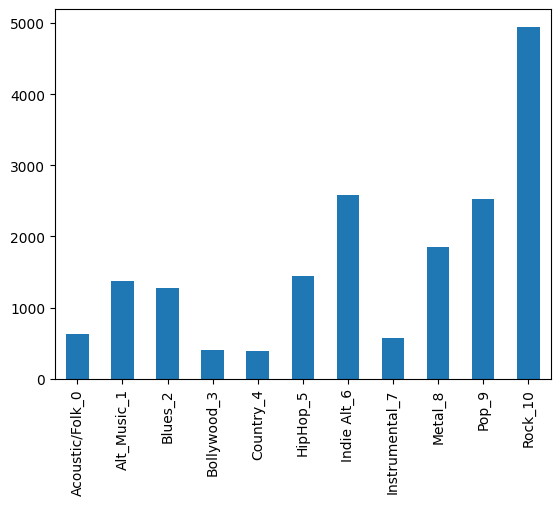

In [19]:
class_name_mapping = {i: name for i, name in enumerate(submission_csv.columns)}
class_counts = train_csv[['Class']].groupby('Class').size()
class_counts.index = pd.Index([class_name_mapping[class_id] for class_id in class_counts.index])
print("Количество объектов данного класса в тренировочном датасете:")
class_counts.plot.bar();

Видим несбалансированные классы, вспоминаем как это может повлиять на Log Loss, будем учитывать это при составлении тестовой и валидационной выборок

In [20]:
print(f"Отношение размера тестового датасета к тренировочному: {len(test_csv) / len(train_csv)}")

Отношение размера тестового датасета к тренировочному: 0.42859524338741944


Понимаем, что наши модели учится на данных примерно вдвое больших чем применяются, это важно для моделей, которые работают лучше при большом количестве данных, чтобы не переоценить их качество из-за маленького теста.

##### Строим пайплайн

Теперь нам надо построить пайплайн, который позволит нам удобно сравнивать подходы и упростит нам жизнь при подготовке финального сабмита. А именно, нам требуется сделать автоматизацию оценки моделей и логгирование их гиперпараметров, артефактов и скоров. Поясним:
1. В соревнованиях и бизнес задачах, в которых требуется много ручного труда, валидирования гипотез и моделей, при большом числе итераций очень важно не терять успешные подходы, поэтому важно вести очень подробное всестороннее логгирование. Отдельно мы проследим, чтобы наше решение было удобно ансамблировать с решениями других участников соревнования или другими моделями, для получения лучшей генерализации, при помощи такого мощного подхода как стекинг.
2. Перед тем как отправить сабмит в тестирующую систему соревнования, которые зачастую ограничивают число попыток, или, если мы не хотим светить своим большим скором на лидерборде, а тем более в бизнесе, когда деплой некачественной модели означает непредвиденную потерю ресурсов, очень важно иметь четкое представление о ее перформансе, причем представление должно хорошо коррелировать с оценкой соревнования или бизнес-метриками.

С учетом размеров тестового и тренировочного датасетов, отщепим от трейна кусочек ~3k записей для локального теста, и разобьем на 3 кроссвалидационные выборки в отношении 2:1 (10000:5000) стратифицированным образом (с сохранением пропорций размеров классов). \
**Важно! Индексы разбиения надо сохранить в виде файла, который можно шерить в рамках гипотетической команды в соревновании. Просто случайного сида недостаточно, так как его применение может быть платформозависимым.**

In [21]:
import pickle 
import os
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

filename = 'indices.pckl'
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        indices = pickle.load(f)
else:
    indices = {}
    indices['train_indices'], indices['test_indices'] = train_test_split(
        np.arange(len(train_csv)),
        test_size=2996,
        stratify=train_csv['Class'],
        shuffle=True,
        random_state=0xBA0BAB
    )

    train_df = train_csv.iloc[indices['train_indices']]
    cv_splitter = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=0xBED
    )
    indices['cv_iterable'] = []
    for train_indices, val_indices in cv_splitter.split(train_df.drop('Class', axis=1), train_df['Class']):
        indices['cv_iterable'].append(
            (train_indices, val_indices)
        )
    with open(filename, 'wb+') as f:
        pickle.dump(indices, f)

In [22]:
train_indices = indices['train_indices']
test_indices = indices['test_indices']
cv_iterable = indices['cv_iterable']
X_train = train_csv.iloc[train_indices].drop('Class', axis=1)
y_train = train_csv.iloc[train_indices]['Class']
X_test = train_csv.iloc[test_indices].drop('Class', axis=1)
y_test = train_csv.iloc[test_indices]['Class']

**7. (2 балла)** Загрузите в Контест решение седьмой задачи (см. файл `src.py`).

In [24]:
from src import Logger, ExperimentHandler

from sklearn.metrics import average_precision_score, log_loss

logger = Logger('./logs')
scorer = ExperimentHandler(
    X_train, y_train, X_test, y_test, cv_iterable, logger, 
    metrics={
        'BalancedAccuracy': 'balanced_accuracy',
        'NegLogLoss': 'neg_log_loss'
    }
)

В качестве тестовой модели будем использовать логистическую регрессию с самыми базовыми гиперпараметрами и SoftMax'ом.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

log_reg_pipeline = Pipeline(
    [
        (
            'extract numeric features', 
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='mean')
        ),
        (
            'normalize features',
            StandardScaler()
        ),
        (
            'estimator',
            LogisticRegression(multi_class='multinomial', max_iter=10000, random_state=0x5EED)
        )
    ]
)

In [26]:
scorer.run(log_reg_pipeline, name='logreg')

/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._storage.append(pd.Series(name=name))
/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._storage.append(pd.Series(name=name))


,BalancedAccuracy_mean,BalancedAccuracy_std,NegLogLoss_mean,NegLogLoss_std,BalancedAccuracy_test,NegLogLoss_test
id,,,,,,
logreg,0.524767,0.005606,-1.349075,0.008689,0.498822,-1.36072


##### Тестируем базовые модели

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sys

tree_pipeline = Pipeline(
    [
        (
            'extract numeric features', 
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            DecisionTreeClassifier(max_depth=10, random_state=0x5EED)
        )
    ]
)

forest_pipeline = Pipeline(
    [
        (
            'extract numeric features', 
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            RandomForestClassifier(n_estimators=200, random_state=0x5EED)
        )
    ]
)

In [28]:
scorer.run(tree_pipeline, name='tree')
scorer.run(forest_pipeline, name='forest')
scorer.logger.leaderboard

/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._storage.append(pd.Series(name=name))
/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._storage.append(pd.Series(name=name))
/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._storage.append(pd.Series(name=name))
/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._storage.append(pd.Series(name=name))


,BalancedAccuracy_mean,BalancedAccuracy_std,NegLogLoss_mean,NegLogLoss_std,BalancedAccuracy_test,NegLogLoss_test
id,,,,,,
logreg,0.524767,0.005606,-1.349075,0.008689,0.498822,-1.360720
tree,0.492979,0.002465,-4.408344,0.158612,0.502023,-3.582191
forest,0.557242,0.005756,-1.423644,0.004199,0.568000,-1.458474


Можно пронаблюдать, что ни дерево, ни лес не побеждают линейную регрессию. Зато можно их скомбинировать, усредняя подобно лесу или при помощи стекинга — это еще один хороший метод ансамблирования. Поскольку мы написали экспериментальны пайплайн так, чтобы это было просто устроить, воспользуемся этим.

In [29]:
class AverageTestClassifier:
    def __init__(self, *names, experiment_handler):
        _, stacking_predicitons_test = experiment_handler.get_stacking_predictions(names)
        self.test_predictions = sum(
            stacking_predicitons_test.loc[:, stacking_predicitons_test.columns.str.startswith(name)].values for name in names
        ) / len(names)
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return np.argmax(self.test_predictions, axis=1)
    
    def predict_proba(self, X):
        return self.test_predictions

In [30]:
estimator = AverageTestClassifier('logreg', 'forest', experiment_handler=scorer)
with scorer.logger.run(name='forest+logreg_averaging') as run:
    scorer.score_test(estimator, metrics=scorer.get_metrics(estimator), run=run)

/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._storage.append(pd.Series(name=name))
/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._storage.append(pd.Series(name=name))


In [31]:
scorer.logger.leaderboard

,BalancedAccuracy_mean,BalancedAccuracy_std,NegLogLoss_mean,NegLogLoss_std,BalancedAccuracy_test,NegLogLoss_test
id,,,,,,
logreg,0.524767,0.005606,-1.349075,0.008689,0.498822,-1.360720
tree,0.492979,0.002465,-4.408344,0.158612,0.502023,-3.582191
forest,0.557242,0.005756,-1.423644,0.004199,0.568000,-1.458474
forest+logreg_averaging,NaN,NaN,NaN,NaN,0.539617,-1.318392


Как видим усреднять плохой предиктор с хорошим может нанести вред качеству модели. Но стекинг с линейной моделью в качестве финального эстиматора исправляет эту ситуацию, так как разным предикторам даются разные веса.

In [32]:
class StackingCVClassifier:
    def __init__(self, *names, base_estimator, experiment_handler):
        self.stacking_predictions_train, self.stacking_predictions_test = experiment_handler.get_stacking_predictions(names)
        self.base_estimator = base_estimator
        
    def fit(self, X, y):
        X_train_with_stacking_predictions = pd.concat([X, self.stacking_predictions_train], axis=1)
        return self.base_estimator.fit(X_train_with_stacking_predictions, y)
    
    def predict(self, X):
        X_test_with_stacking_predictions = pd.concat([X, self.stacking_predictions_test], axis=1)
        return self.base_estimator.predict(X_test_with_stacking_predictions)
    
    def predict_proba(self, X):
        X_test_with_stacking_predictions = pd.concat([X, self.stacking_predictions_test], axis=1)
        return self.base_estimator.predict_proba(X_test_with_stacking_predictions)

In [33]:
estimator = StackingCVClassifier('tree', 'forest', base_estimator=log_reg_pipeline, experiment_handler=scorer)
with scorer.logger.run(name='forest+tree_stacking_with_logreg') as run:
    estimator.fit(X_train, y_train)
    scorer.score_test(estimator, metrics=scorer.get_metrics(estimator), run=run)

/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._storage.append(pd.Series(name=name))
/home/avalur/autohw/dt/ref_experiment_handler.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._storage.append(pd.Series(name=name))


In [34]:
scorer.logger.leaderboard

,BalancedAccuracy_mean,BalancedAccuracy_std,NegLogLoss_mean,NegLogLoss_std,BalancedAccuracy_test,NegLogLoss_test
id,,,,,,
logreg,0.524767,0.005606,-1.349075,0.008689,0.498822,-1.360720
tree,0.492979,0.002465,-4.408344,0.158612,0.502023,-3.582191
forest,0.557242,0.005756,-1.423644,0.004199,0.568000,-1.458474
forest+logreg_averaging,NaN,NaN,NaN,NaN,0.539617,-1.318392
forest+tree_stacking_with_logreg,NaN,NaN,NaN,NaN,0.605892,-1.171310


**Задание, получите при помощи фичаинжиниринга как можно более хорошее качество на тесте (и кроссвалидации) оглядываясь на получающийся лидерборд разными способами, Затем постекайте и получите еще прирост качества: поздравляем, вы готовы врываться в соревнования!**